In [1]:
import numpy as np
import pandas as pd
import scipy.stats as ss
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.mixture import GaussianMixture
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from scipy.stats import multivariate_normal
from itertools import chain
from matplotlib.patches import Ellipse


sns.set_context('notebook')
sns.set_style('white')

def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn
warnings.filterwarnings('ignore')

In [2]:
# This function will allow us to easily plot data taking in x values, y values, and a title
def plot_univariate_mixture(means, stds, weights, N = 10000, seed=10):

    """
    returns the simulated 1d dataset X, a figure, and the figure's ax

    """
    np.random.seed(seed)
    if not len(means)==len(stds)==len(weights):
        raise Exception("Length of mean, std, and weights don't match.")
    K = len(means)

    mixture_idx = np.random.choice(K, size=N, replace=True, p=weights)
    # generate N possible values of the mixture
    X = np.fromiter((ss.norm.rvs(loc=means[i], scale=stds[i]) for i in mixture_idx), dtype=np.float64)

    # generate values on the x axis of the plot
    xs = np.linspace(X.min(), X.max(), 300)
    ps = np.zeros_like(xs)

    for mu, s, w in zip(means, stds, weights):
        ps += ss.norm.pdf(xs, loc=mu, scale=s) * w

    fig, ax = plt.subplots()
    ax.plot(xs, ps, label='pdf of the Gaussian mixture')
    ax.set_xlabel("X", fontsize=15)
    ax.set_ylabel("P", fontsize=15)
    ax.set_title("Univariate Gaussian mixture", fontsize=15)
    #plt.show()

    return X.reshape(-1,1), fig, ax


def plot_bivariate_mixture(means, covs, weights, N = 10000, seed=10):

    """
    returns the simulated 2d dataset X and a scatter plot is shown

    """
    np.random.seed(seed)
    if not len(mean)==len(covs)==len(weights):
        raise Exception("Length of mean, std, and weights don't match.")
    K = len(means)
    M = len(means[0])

    mixture_idx = np.random.choice(K, size=N, replace=True, p=weights)

    # generate N possible values of the mixture
    X = np.fromiter(chain.from_iterable(multivariate_normal.rvs(mean=means[i], cov=covs[i]) for i in mixture_idx),
                dtype=float)
    X.shape = N, M

    xs1 = X[:,0]
    xs2 = X[:,1]

    plt.scatter(xs1, xs2, label="data")

    L = len(means)
    for l, pair in enumerate(means):
        plt.scatter(pair[0], pair[1], color='red')
        if l == L-1:
            break
    plt.scatter(pair[0], pair[1], color='red', label="mean")

    plt.xlabel("$x_1$")
    plt.ylabel("$x_2$")
    plt.title("Scatter plot of the bivariate Gaussian mixture")
    plt.legend()
    plt.show()

    return X


def draw_ellipse(position, covariance, ax=None, **kwargs):

    """
    Draw an ellipse with a given position and covariance

    """
    ax = ax or plt.gca()

    # Convert covariance to principal axes
    if covariance.shape == (2, 2):
        U, s, Vt = np.linalg.svd(covariance)
        angle = np.degrees(np.arctan2(U[1, 0], U[0, 0]))
        width, height = 2 * np.sqrt(s)
    else:
        angle = 0
        width, height = 2 * np.sqrt(covariance)

    # Draw the Ellipse
    for nsig in range(1, 4):
        ax.add_patch(Ellipse(position, nsig * width, nsig * height, angle, **kwargs))


def plot_gmm(gmm, X, label=True, ax=None):
    ax = ax or plt.gca()
    labels = gmm.fit(X).predict(X)
    if label:
        ax.scatter(X[:, 0], X[:, 1], c=labels, s=40, cmap='viridis', zorder=2)
    else:
        ax.scatter(X[:, 0], X[:, 1], s=40, zorder=2)
    ax.axis('equal')

    w_factor = 0.2 / gmm.weights_.max()
    for pos, covar, w in zip(gmm.means_, gmm.covariances_, gmm.weights_):
        draw_ellipse(pos, covar, alpha=w * w_factor)

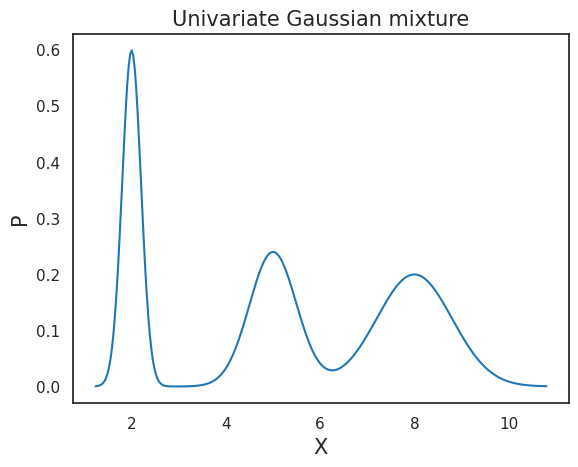

In [3]:
X1, fig1, ax1 = plot_univariate_mixture(means=[2,5,8], stds=[0.2, 0.5, 0.8], weights=[0.3, 0.3, 0.4])

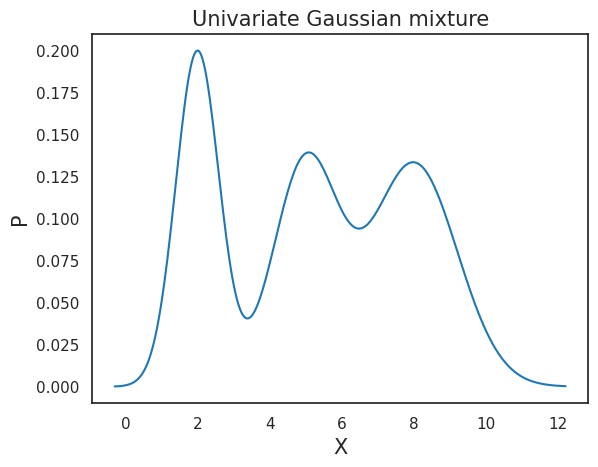

In [4]:
X2, fig2, ax2 = plot_univariate_mixture(means=[2,5,8], stds=[0.6, 0.9, 1.2], weights=[0.3, 0.3, 0.4])

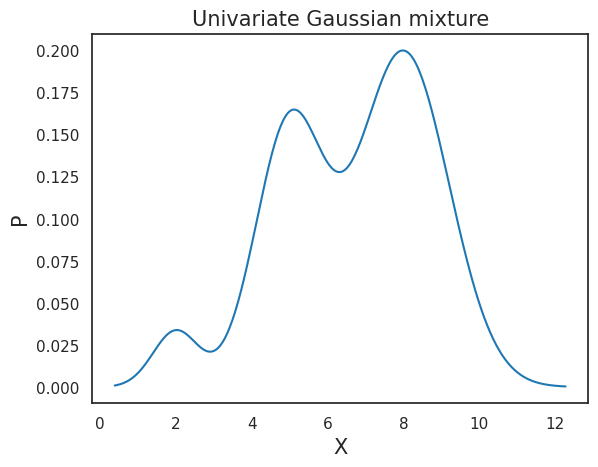

In [5]:
X3, fig3, ax3 = plot_univariate_mixture(means=[2,5,8], stds=[0.6, 0.9, 1.2], weights=[0.05, 0.35, 0.6])

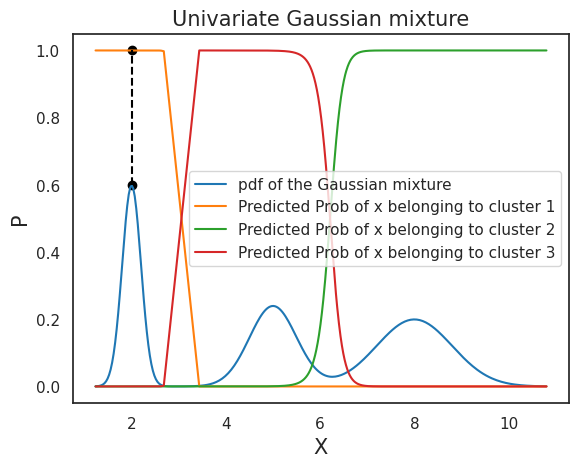

In [6]:
# sort X1 in ascending order for plotting purpose
X1_sorted = np.sort(X1.reshape(-1)).reshape(-1,1)

# fit the GMM
GMM = GaussianMixture(n_components=3, random_state=10)
GMM.fit(X1_sorted)

# store the predicted probabilities in prob_X1
prob_X1 = GMM.predict_proba(X1_sorted)

# start plotting!
ax1.plot(X1_sorted, prob_X1[:,0], label='Predicted Prob of x belonging to cluster 1')
ax1.plot(X1_sorted, prob_X1[:,1], label='Predicted Prob of x belonging to cluster 2')
ax1.plot(X1_sorted, prob_X1[:,2], label='Predicted Prob of x belonging to cluster 3')
ax1.scatter(2, 0.6, color='black')
ax1.scatter(2, 1.0, color='black')
ax1.plot([2, 2], [0.6, 1.0],'--', color='black')
ax1.legend()
fig1

In [10]:
img = plt.imread('/content/drive/MyDrive/DataSets/gauss-cat.jpeg')

# If img is greyscale, then change to .reshape(-1, 1):
X = img.reshape(-1, 3)
# The number of components; you can change this to a positive integer of your choice!:
n = 2
gmm = GaussianMixture(n_components=n, covariance_type='tied')
gmm.fit(X)
labels = gmm.predict(X) # num of pixels x 1

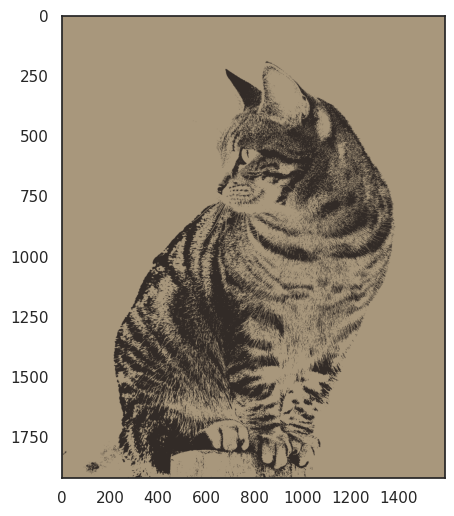

In [11]:
seg = np.zeros(X.shape) # num of pixels x 3

for label in range(n):
    seg[labels == label] = gmm.means_[label]
seg = seg.reshape(img.shape).astype(np.uint8)

plt.figure(figsize=(6,6))
plt.imshow(seg)

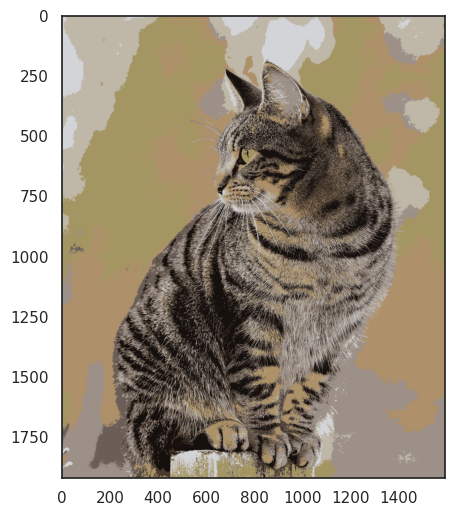

In [12]:
n = 8
gmm = GaussianMixture(n_components=n, covariance_type='tied')
gmm.fit(X)
labels = gmm.predict(X) # num of pixels x 1
seg = np.zeros(X.shape) # num of pixels x 3

for label in range(n):
    seg[labels == label] = gmm.means_[label]
seg = seg.reshape(img.shape).astype(np.uint8)
#cv2.imwrite(f'gauss-cat-{n}.jpeg', seg)

plt.figure(figsize=(6,6))
plt.imshow(seg)
plt.show()

In [13]:
data = pd.read_csv("/content/drive/MyDrive/DataSets/customers.csv")
data.head()

,Education,Income,Kidhome,Teenhome,Recency,Wines,Fruits,Meat,Fish,Sweets,Gold,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,Spent,Living_Status,Children
0,0,58138.0,0,0,58,635,88,546,172,88,88,3,8,10,4,7,1617,0,0
1,0,46344.0,1,1,38,11,1,6,2,1,6,2,1,1,2,5,27,0,2
2,0,71613.0,0,0,26,426,49,127,111,21,42,1,8,2,10,4,776,1,0
3,0,26646.0,1,0,26,11,4,20,10,3,5,2,2,0,4,6,53,1,1
4,1,58293.0,1,0,94,173,43,118,46,27,15,5,5,3,6,5,422,1,1


In [15]:
from sklearn.preprocessing import StandardScaler
SS = StandardScaler()
X = SS.fit(data).transform(data)

In [16]:
from sklearn.decomposition import PCA
pca2 = PCA(n_components=2)
reduced_2_PCA = pca2.fit(X).transform(X)

In [17]:
model = GaussianMixture(n_components=4, random_state=0)
model.fit(reduced_2_PCA)

GaussianMixture(n_components=4, random_state=0)

In [18]:
PCA_2_pred = model.predict(reduced_2_PCA)

Text(0, 0.5, 'PCA 2')

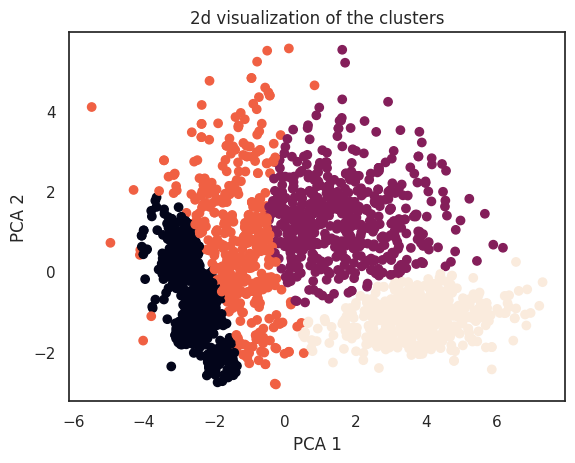

In [19]:
x = reduced_2_PCA[:,0]
y = reduced_2_PCA[:,1]
plt.scatter(x, y, c=PCA_2_pred)
plt.title("2d visualization of the clusters")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")

Text(0.5, 0.92, '3D projection of the clusters')

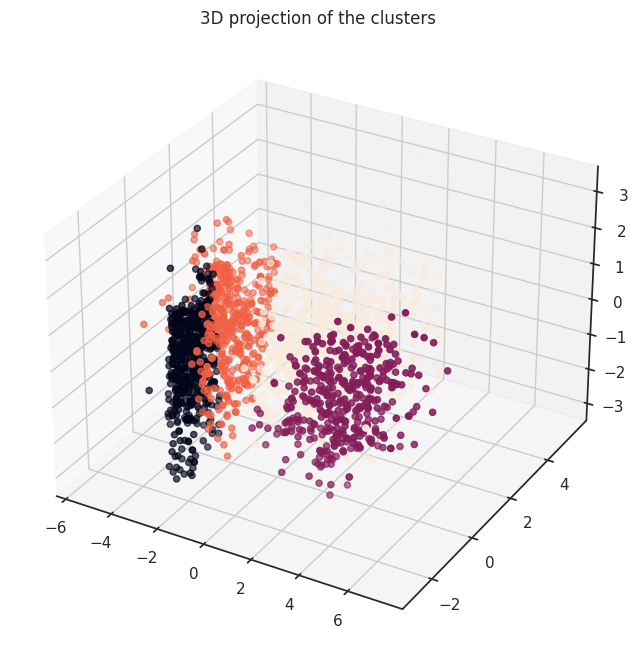

In [20]:
# PCA with n=3 and clustering
pca3 = PCA(n_components=3)
reduced_3_PCA = pca3.fit(X).transform(X)
mod = GaussianMixture(n_components=4, random_state=0)
PCA_3_pred = mod.fit(reduced_3_PCA).predict(reduced_3_PCA)

# plotting
reduced_3_PCA = pd.DataFrame(reduced_3_PCA, columns=(['PCA 1', 'PCA 2', 'PCA 3']))
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111, projection="3d")
ax.scatter(reduced_3_PCA['PCA 1'],reduced_3_PCA['PCA 2'],reduced_3_PCA['PCA 3'], c=PCA_3_pred)
ax.set_title("3D projection of the clusters")